In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from procedures import create_binance_bot, create_binance_bot_spot, create_bybit_bot, load_exchange_key_secret
from pure_funcs import get_template_live_config, ts_to_date, get_daily_from_income
from njit_funcs import round_dynamic
from time import time
import pandas as pd
import matplotlib.pyplot as plt

using numba


In [3]:
plt.rcParams['figure.figsize'] = [21, 13]
pd.set_option('precision', 10)

In [4]:
config = get_template_live_config()
config['market_type'] = 'spot'
config['user'] = 'user_name'
config['exchange'], _, _ = load_exchange_key_secret(config['user'])

n_days = 30
start_time = (time() - 60 * 60 * 24 * n_days) * 1000
end_time = time() * 1000

# specify symbols, except binance usd-m
# binance usd-m futures fetches income for all symbols, otherwise only one symbol at a time
symbols = ['XRPUSDT', 'XLMUSDT', 'ADAUSDT', 'EOSUSDT']
incomes = []
for symbol in (symbols if config['exchange'] == 'bybit' else symbols[:1]):
    config['symbol'] = symbol
    try:
        await bot.session.close()
    except:
        pass
    if config['exchange'] == 'binance':
        if config['market_type'] == 'spot':
            bot = await create_binance_bot_spot(config)
        else:
            bot = await create_binance_bot(config)
    elif config['exchange'] == 'bybit':
        bot = await create_bybit_bot(config)

    await bot.update_position()
    balance = bot.position['wallet_balance']

    income = await bot.get_all_income(start_time)
    incomes += income
idf, bdf = get_daily_from_income(sorted(incomes, key=lambda x: x['timestamp']), bot.position['wallet_balance'],
                                 start_time=start_time, end_time=end_time)


spot market
2021-09-30T15:29:46  fetched fills 2021-09-02T05:25:32.130000 


current balance 0.068267
abs sum 0.004307 ETH
abs adg 0.0001436 ETH
pct sum 0.06309
pct adg 0.00204


<AxesSubplot:xlabel='timestamp'>

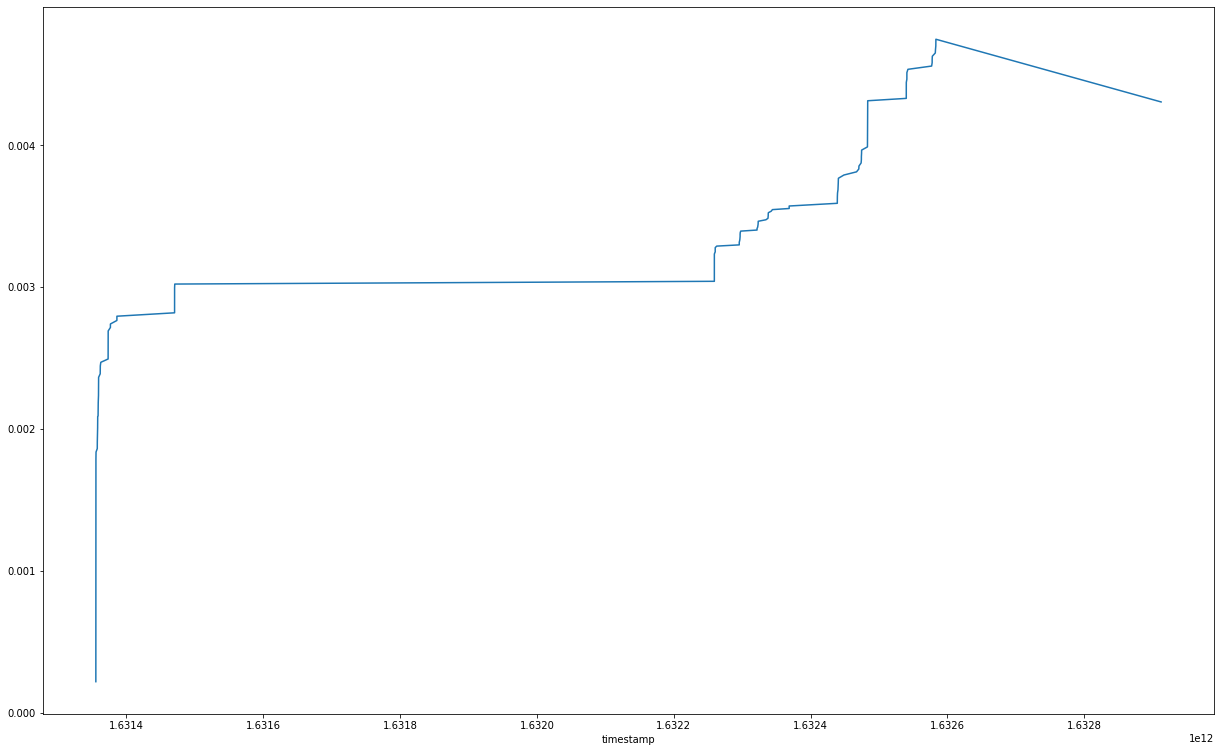

In [5]:
print(f'current balance {round_dynamic(balance, 5)}')
print(f'abs sum {round_dynamic(idf.income.sum(), 4)} {idf.iloc[-1]["token"]}')
print(f'abs adg {round_dynamic(idf.income.sum() / n_days, 4)} {idf.iloc[-1]["token"]}')
print(f'pct sum {((balance + idf.income.sum()) / balance) - 1:.5f}')
print(f'pct adg {((balance + idf.income.sum()) / balance) ** (1 / n_days) - 1:.5f}')

idf.income.cumsum().plot()

In [6]:
idf.tail(20)

,symbol,income_type,income,token,timestamp,info,transaction_id,trade_id,datetime
timestamp,,,,,,,,,
1632483607227,ADAETH,realized_pnl,0.0000228544,ETH,1632483607227,0,21442653,21442653,2021-09-24T13:40:07.227000
1632539955173,ADAETH,realized_pnl,0.0000166924,ETH,1632539955173,0,21479368,21479368,2021-09-25T05:19:15.173000
1632539957931,ADAETH,realized_pnl,0.0000166924,ETH,1632539957931,0,21479381,21479381,2021-09-25T05:19:17.931000
1632539958033,ADAETH,realized_pnl,0.0000229924,ETH,1632539958033,0,21479539,21479539,2021-09-25T05:19:18.033000
1632539959257,ADAETH,realized_pnl,0.0000304822,ETH,1632539959257,0,21479614,21479614,2021-09-25T05:19:19.257000
1632540014923,ADAETH,realized_pnl,0.0000427889,ETH,1632540014923,0,21479896,21479896,2021-09-25T05:20:14.923000
1632540825250,ADAETH,realized_pnl,0.0000224619,ETH,1632540825250,0,21480740,21480740,2021-09-25T05:33:45.250000
1632540838033,ADAETH,realized_pnl,0.0000235977,ETH,1632540838033,0,21481109,21481109,2021-09-25T05:33:58.033000
1632540873993,ADAETH,realized_pnl,0.0000228735,ETH,1632540873993,0,21481478,21481478,2021-09-25T05:34:33.993000


In [7]:
bdf

,abs_income,gain,cumulative
2021-08-31T02:00:00,0.0000000000,0.0000000000,0.0639607769
2021-09-01T02:00:00,0.0000000000,0.0000000000,0.0639607769
2021-09-02T02:00:00,0.0000000000,0.0000000000,0.0639607769
2021-09-03T02:00:00,0.0000000000,0.0000000000,0.0639607769
2021-09-04T02:00:00,0.0000000000,0.0000000000,0.0639607769
2021-09-05T02:00:00,0.0000000000,0.0000000000,0.0639607769
2021-09-06T02:00:00,0.0000000000,0.0000000000,0.0639607769
2021-09-07T02:00:00,0.0000000000,0.0000000000,0.0639607769
2021-09-08T02:00:00,0.0000000000,0.0000000000,0.0639607769
2021-09-09T02:00:00,0.0000000000,0.0000000000,0.0639607769


<AxesSubplot:>

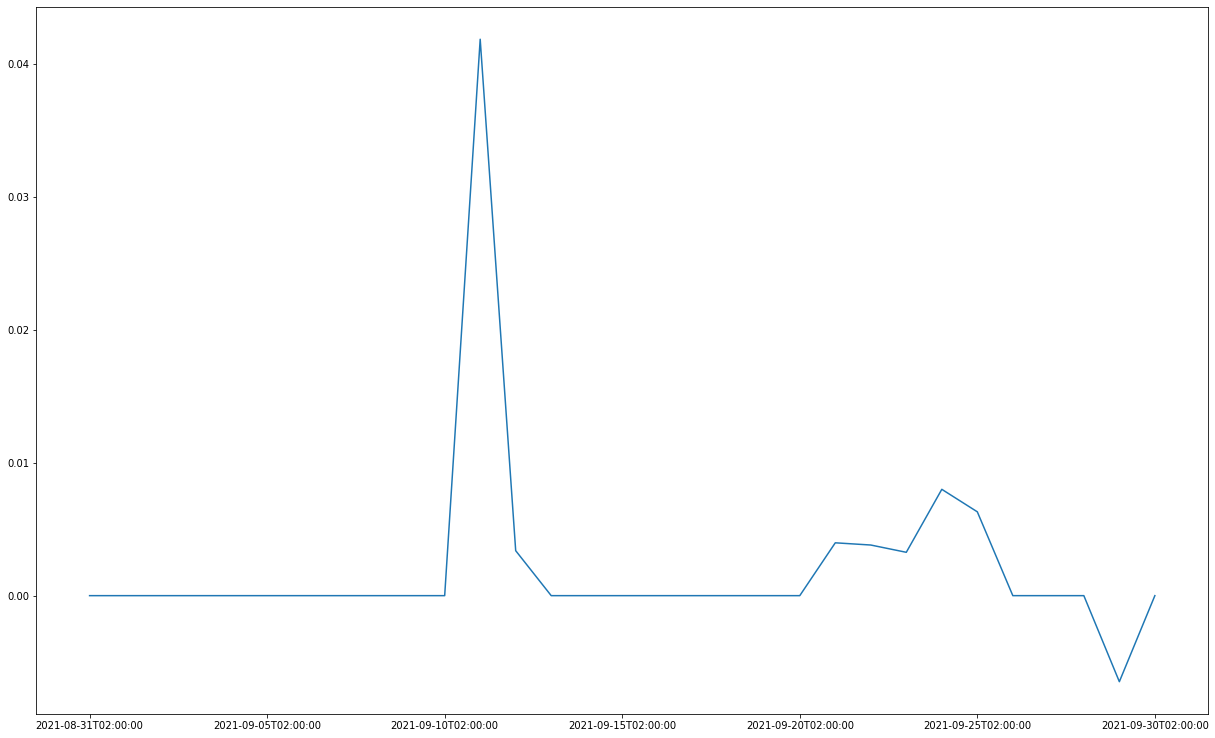

In [8]:
bdf.gain.plot()

In [9]:
# check income last x days
x = 3
since = (time() - 60 * 60 * 24 * x) * 1000
idf[idf.timestamp > since].groupby('symbol').income.sum().sort_values()

symbol
ADAETH   -0.0004420803
Name: income, dtype: float64